# Importing Libraries

In [ ]:
from torchvision import models
import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import os
import glob
from PIL import Image
import h5py
import cv2
import time
import json
from matplotlib.colors import LinearSegmentedColormap
import scipy.fftpack as fp
from google.colab import files
from model_classes import * 

# Function Defintion

In [ ]:
def gabor_filtering(img):
  kernel = cv2.getGaborKernel((7, 7), 2, 0, 5, 10, 0, cv2.CV_32F)
  kernel /= math.sqrt((kernel * kernel).sum())
  return cv2.filter2D(img, -1, kernel)
  
def load_prev(model,path):
  model.load_state_dict(torch.load(path)) 
  model = model.to(device)
  return model
  
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    im = np.array(im)
    ### Need to give credits to the original author who suggested this image transformation
    im = im/255.0
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225
    return im

def get_input(path):
    img = create_img(path)
    return(img)
    
def get_output(path):
    gt_file = h5py.File(path,'r')
    target = np.asarray(gt_file['density'])
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64 ### why shrink the size of the ground truth ???
    return img

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)



im2freq = lambda data: fp.rfft(fp.rfft(data, axis=0),axis=1)
freq2im = lambda f: fp.irfft(fp.irfft(f, axis=1),axis=0)

# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root = 'drive/My Drive/Downloads/data'

Mounted at /content/drive


# Loading Dataset Paths -- this

In [ ]:
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
temp = 'test_images'
path_sets = [part_B_train] # analysis -- > separately train on A, B and then AB
test_path_sets = [part_B_test]

In [ ]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(str(img_path))
print("Total images : ",len(img_paths))

test_img_paths = []
for path in test_path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        test_img_paths.append(str(img_path))
print("Total images : ",len(test_img_paths))

Total images :  400
Total images :  316


In [ ]:
train_paths,val_paths = train_test_split(img_paths, test_size=0.2)

# Model Class Definition

In [ ]:
class Mobile_CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(Mobile_CSRNet, self).__init__()
        mobilenet = models.mobilenet_v2()
        in_ch = 64 # input channels to backend
        self.backend_feat  = [in_ch,16]
        self.backend = make_layers(self.backend_feat,in_channels = in_ch,dilation = True)
        self.output_layer = nn.Conv2d(16, 1, kernel_size=1)
        self.frontend = mobilenet.features[:9]
        for param in self.frontend.parameters():
          param.requires_grad = False
        for param in self.backend.parameters():
          param.requires_grad = True
        for param in self.output_layer.parameters():
          param.requires_grad = True
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return torch.abs(x)
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

class Mobile_CSRNet_regressor(nn.Module):
    def __init__(self): 
        super(Mobile_CSRNet_regressor, self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(1,10),         
            nn.ReLU(),
            nn.Linear(10,25),
            nn.ReLU(),
            nn.Linear(25,1)
        )

    def forward(self, x):
        x = self.fc_model(x)
        return x

# Porting to GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = Mobile_CSRNet().to(device)

def my_loss(output, target):
    loss = 10*torch.mean((torch.max(output) - torch.max(target))**2)
    loss += 10*torch.mean((torch.min(output) - torch.min(target))**2)
    loss += torch.mean( (torch.sum(output)-torch.sum(target))**2 )
    return loss

#loss_fn = my_loss
loss_fn = nn.MSELoss() 
opt = optim.Adam(model.parameters(),lr=0.0006)

cuda:0


# Training

In [ ]:
save_immediately = True
load_prev_model = False # True if want to load previously trained model and want to retrain for few more epochs
mirror = False
model_savename = "Mobile_CSRNet_B_gabor_mse_mirror_2"
output_dir = "/content/Mobile_CSRNet_B_gabor_mse_mirror_2/"
os.mkdir(output_dir)

In [ ]:
if(load_prev_model):  
  model.load_state_dict(torch.load(output_dir+model_savename+".txt")) # loads previous weights
model = model.to(device)

# if you want to load previous model then...
# do... model = <class_name>() # initialize appropriate model: Ex: model = Mobile_CSRNet_V2()
# copy the path to the previously trained model # Ex: prev_model_path = "/content/model_name.txt"
# call the function to load previous weights # Ex: model = load_prev(model, prev_model_path)
# now the model returned by load_prev is a pre-trained model

9676.149299706984 11963.922610425949
Time taken: 313.83
Epoch: 1/100
8411.893612787408 12933.346290107816
Time taken: 49.558
Epoch: 2/100
9181.466783645132 11908.27428118189
Time taken: 49.311
Epoch: 3/100
7706.454285402528 11933.596717386692
Time taken: 49.308
Epoch: 4/100
6996.789381157001 12157.52103744559
Time taken: 49.372
Epoch: 5/100
6971.278955228254 12336.678571891709
Time taken: 48.895
Epoch: 6/100
7234.361977760261 13831.137400329113
Time taken: 48.735
Epoch: 7/100
6990.713992707827 11929.342772221566
Time taken: 48.259
Epoch: 8/100
6376.724503983258 12176.853110766411
Time taken: 48.016
Epoch: 9/100
7003.738580540766 12082.371569228359
Time taken: 47.855
Epoch: 10/100
6736.227599654812 11915.191714394092
Time taken: 48.015
Epoch: 11/100
6529.4816443178115 11903.077017989755
Time taken: 48.209
Epoch: 12/100
5987.382238809572 12030.180799055099
Time taken: 47.646
Epoch: 13/100
6190.197943146899 12347.801446282863
Time taken: 47.32
Epoch: 14/100
6145.482457516901 12048.8359393

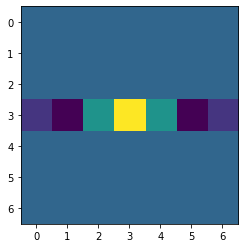

In [ ]:
trainloader = torch.utils.data.DataLoader(train_paths, batch_size=1, shuffle=True)
valloader = torch.utils.data.DataLoader(val_paths, batch_size=1, shuffle=True)
max_epochs = 100

train_loss = []
val_loss = []

if(mirror == True):
  mirror = 1

for epoch in range(max_epochs):
  tic = time.time()
  tmp = []
  
  for i, data in enumerate(trainloader, 0):
    for j in range(1+mirror):
        inputt = get_input(data[0])
        inputt = np.where(j>0,inputt[...,::-1,:],inputt)
        inputt = gabor_filtering(inputt) # gabor filtering : ref: https://subscription.packtpub.com/book/application_development/9781788474443/2/ch02lvl1sec38/processing-images-with-real-valued-gabor-filters
        inputt = np.transpose(inputt, (2,0,1))
        inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
        inputt = torch.tensor(inputt).float()
        ground_truth = torch.tensor(get_output(data[0].replace('.jpg','.h5').replace('images','ground')) )
        inputt, ground_truth = inputt.to(device), ground_truth.to(device)
        opt.zero_grad()
        model_output = model(inputt) # <-
        loss = loss_fn(torch.sum(model_output), torch.sum(ground_truth))
        #loss = loss_fn(model_output, ground_truth)
        loss.backward()
        opt.step()
        tmp.append(loss.item())
  train_loss.append(np.mean(tmp))
  tmp = []
  
  for i, data in enumerate(valloader, 0):
    for j in range(1+mirror):
      inputt = get_input(data[0])
      inputt = np.where(j>0,inputt[...,::-1,:],inputt)
      inputt = np.transpose(inputt, (2,0,1))
      inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
      inputt = torch.tensor(inputt).float()
      ground_truth = torch.tensor(get_output(data[0].replace('.jpg','.h5').replace('images','ground')) )
      inputt, ground_truth = inputt.to(device), ground_truth.to(device)
      opt.zero_grad()
      model_output = model(inputt) # <-
      #loss = loss_fn(model_output, ground_truth)
      loss = loss_fn(torch.sum(model_output), torch.sum(ground_truth))
      tmp.append(loss.item())

  val_loss.append(np.mean(tmp))
  print(train_loss[-1], val_loss[-1])
  toc = time.time()
  print("Time taken: {}".format(np.round(toc-tic,3)))
  print('Epoch: %d/%d' % (epoch+1, max_epochs))

if(save_immediately):
  torch.save(model.state_dict(),output_dir+model_savename+".txt")

# Loss curve and Performance metrics

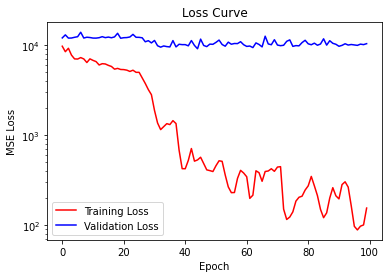

In [ ]:
plt.semilogy(train_loss,'r',label='Training Loss')
plt.semilogy(val_loss,'b',label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Loss Curve")
plt.savefig(output_dir+"MobileNet_B_loss_curve_100_MSE_Adam_gabor_mirror_2.png",bbox_inches = "tight")

# Sample - Misc

In [ ]:
def get_sample_imgs(img_paths, FFT=False):
  n = np.random.randint(0,len(img_paths))
  inputt = get_input(img_paths[n])
  inputt = gabor_filtering(inputt)
  inputt = np.transpose(inputt, (2,0,1))
  inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
  inputt = torch.tensor(inputt).float()
  ground_truth = torch.tensor(get_output(img_paths[n].replace('.jpg','.h5').replace('images','ground')))
  inputt, ground_truth = inputt.to(device), ground_truth.to(device)
  model_output = model(inputt)
  model_output = model_output.to('cpu').detach().numpy()
  ground_truth = ground_truth.to('cpu').numpy()
  return model_output[0][0], ground_truth

In [ ]:
def plot_portraits(img_paths, n_row=1, n_col=2, save_fig=True,save_dir='Output-images/',save_name='Eigen_faces', FFT=False):
    plt.figure(figsize=(5 * n_col, 5 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row):
        img_model,img_gt = get_sample_imgs(img_paths,FFT)
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(img_model)
        plt.colorbar(shrink=0.6)
        plt.xticks(())
        plt.yticks(())
        plt.subplot(n_row, n_col, i + 2)
        plt.imshow(img_gt)
        plt.colorbar(shrink=0.6)
        plt.xticks(())
        plt.yticks(())
    if(save_fig):
      plt.savefig(save_dir+save_name+'.png')

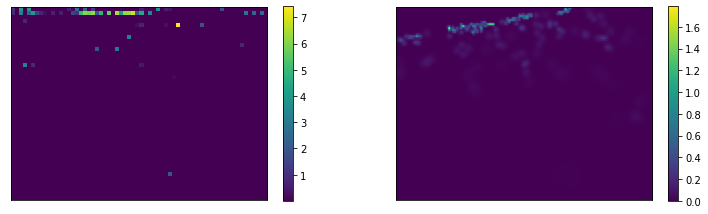

In [ ]:
plot_portraits(img_paths,save_dir=output_dir,save_name='samples3')

# Saving Model outputs to .npy files

In [ ]:
if(not os.path.isdir(output_dir+"model_density_maps/")):
  os.mkdir(output_dir+"model_density_maps/")
  model_hmap_paths = output_dir+"model_density_maps/"
model_hmap_sum = []
gt_sum = []
for i, data in enumerate(img_paths, 0):
  inputt = get_input(data)
  inputt = np.transpose(inputt, (2,0,1))
  inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
  inputt = torch.tensor(inputt).float()
  inputt = inputt.to(device)
  gt_sum.append([data,float(np.sum(get_output(data.replace('.jpg','.h5').replace('images','ground'))))])
  model_output = model(inputt)
  model_output = model_output.to('cpu').detach().numpy()
  model_hmap_sum.append([data,float(np.sum(model_output))])
  f_name = data.split('/')[-1]
  f_name = f_name.split('.')
  f_name = f_name[0]+'_model_density_map.npy'
  np.save(model_hmap_paths+"{}".format(f_name), model_output)
with open(model_hmap_paths+'model_hmap_sum.json', 'w') as f:
  json.dump(model_hmap_sum, f)
with open(model_hmap_paths+'gt_sum.json', 'w') as f:
  json.dump(gt_sum, f)

# Regressor

In [ ]:
class Regressor(nn.Module):
    def __init__(self): 
        super(Regressor, self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(1,10),         
            nn.ReLU(),
            nn.Linear(10,25),
            nn.ReLU(),
            nn.Linear(25,1)
        )

    def forward(self, x):
        x = self.fc_model(x)
        return x

In [ ]:
model_hmap_paths = output_dir+"model_density_maps/"
f = open(model_hmap_paths+'model_hmap_sum.json',) 
model_hmap_sum = json.load(f)
regdata = np.array([row[-1] for row in model_hmap_sum]).reshape(-1,1)
f = open(model_hmap_paths+'gt_sum.json',) 
gt_sum = json.load(f)
gtsum = np.array([row[-1] for row in gt_sum]).reshape(-1,1)

In [ ]:
regdata = torch.tensor(regdata).float().to(device)
gtsum = torch.tensor(gtsum).float().to(device)

In [ ]:
regloader = torch.utils.data.DataLoader(model_hmap_paths, batch_size=1, shuffle=True)
regnet = Regressor().to(device)
loss_fn = nn.MSELoss()
opt = optim.Adam(regnet.parameters())

In [ ]:
regressor_savename = "MobileNet_B_regressor_100_MSE_Adam_gabor_mirror_2"
if(load_prev_model):  
  regnet.load_state_dict(torch.load(output_dir+regressor_savename+".txt")) # loads previous weights
regnet = regnet.to(device)

In [ ]:
max_epochs = 1000
train_loss = []
train_acc_arr = []

for epoch in range(max_epochs):
  opt.zero_grad()
  model_output = regnet(regdata)
  loss = loss_fn(model_output, gtsum)
  loss.backward()
  opt.step()
  train_loss.append(loss.item())
  #print('Epoch: %d/%d' % (epoch, max_epochs))

In [ ]:
regdata[0], regnet(regdata[0]), gtsum[0]

(tensor([174.5368], device='cuda:0'),
 tensor([180.5891], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([228.9645], device='cuda:0'))

In [ ]:
torch.save(regnet.state_dict(),output_dir+regressor_savename+".txt") # regressor model saved

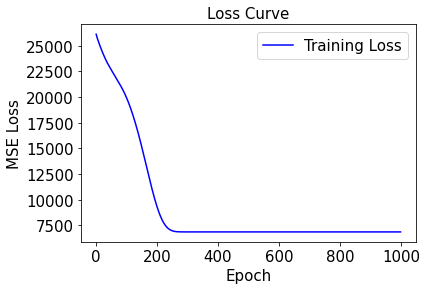

In [ ]:
plt.plot(train_loss,'b',label='Training Loss')
plt.xlabel("Epoch",fontsize=15)
plt.ylabel("MSE Loss",fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Loss Curve",fontsize=15)
plt.savefig(output_dir+"MobileNet_B_regressor_loss_curve_100_MSE_Adam_gabor_mirror_2.png",bbox_inches = "tight")

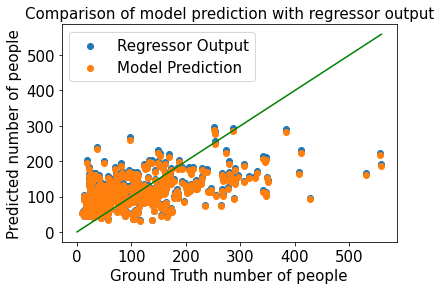

In [ ]:
model_sum = regnet(regdata).detach().cpu().numpy()
gt_sum = gtsum.cpu().numpy()
x = np.linspace(0,np.amax(gt_sum),1000)
reg_data = regdata.cpu().numpy()
plt.scatter(gt_sum,model_sum, label="Regressor Output")
plt.scatter(gt_sum,reg_data, label="Model Prediction")
plt.plot(x,x,'g')
plt.xlabel("Ground Truth number of people",fontsize=15)
plt.ylabel("Predicted number of people",fontsize=15)
plt.legend(fontsize=15)
plt.title("Comparison of model prediction with regressor output",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(output_dir+"comparison.png", bbox_inches="tight")

# Testing

In [ ]:
'''model_output = {}
testloader = torch.utils.data.DataLoader(test_img_paths, batch_size=1, shuffle=True)
tic = time.time()
tmp = []
for i, data in enumerate(testloader, 0):
  inputt = get_input(data[0])
  inputt = np.transpose(inputt, (2,0,1))
  inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
  inputt = torch.tensor(inputt).float()
  inputt = inputt.to(device)
  model_output[i] = model(inputt) # <-
toc = time.time()
print("Time taken: {}".format(np.round(toc-tic,3)))'''

Time taken: 5.528


In [ ]:
test_model_sum = np.array([])
test_gt_sum = np.array([])
testloader = torch.utils.data.DataLoader(test_img_paths, batch_size=1, shuffle=True)
tic = time.time()
tmp = []
for i, data in enumerate(testloader, 0):
  inputt = get_input(data[0])
  inputt = np.transpose(inputt, (2,0,1))
  inputt = inputt.reshape(1,inputt.shape[0],inputt.shape[1],inputt.shape[2])
  inputt = torch.tensor(inputt).float()
  ground_truth = torch.tensor(get_output(data[0].replace('.jpg','.h5').replace('images','ground')) )
  inputt, ground_truth = inputt.to(device), ground_truth.to(device)
  opt.zero_grad()
  model_output = model(inputt) # <-
  loss = loss_fn(torch.sum(model_output), torch.sum(ground_truth))
  tmp.append(loss.item())
  reg_pred = torch.tensor([torch.sum(model_output)]).to(device)#.reshape(-1,1)
  reg_pred = regnet(reg_pred).detach().cpu().item()
  test_model_sum = np.append(test_model_sum,reg_pred)
  test_gt_sum = np.append(test_gt_sum,np.sum(ground_truth.cpu().numpy()))
print("Mean Test Loss: ",np.mean(tmp))
print("Mean Residual: ",np.mean(np.abs(test_model_sum-test_gt_sum)))
print("% Non-Linearity: ",np.mean(100*np.abs(1-(test_gt_sum/test_model_sum))))
toc = time.time()
print("Time taken: {}".format(np.round(toc-tic,3)))

Mean Test Loss:  8438.892844165097
Mean Residual:  67.7445170185234
% Non-Linearity:  56.104792628427795
Time taken: 230.987


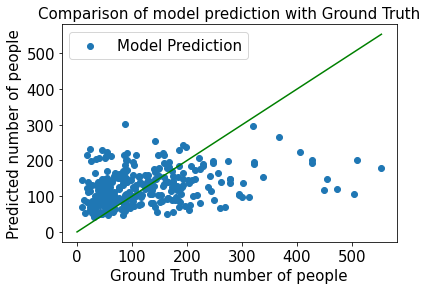

In [ ]:
x_test = np.linspace(0,np.amax(test_gt_sum))
plt.scatter(test_gt_sum,test_model_sum,label="Model Prediction")
plt.plot(x_test,x_test,'g')
plt.xlabel("Ground Truth number of people",fontsize=15)
plt.ylabel("Predicted number of people",fontsize=15)
plt.legend(fontsize=15)
plt.title("Comparison of model prediction with Ground Truth",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(output_dir+"test_comparison.png", bbox_inches="tight")

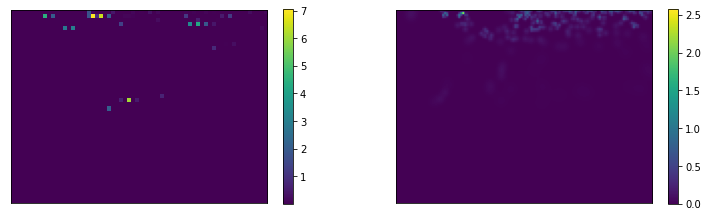

In [ ]:
plot_portraits(test_img_paths,save_dir=output_dir,save_name='test_samples0')

# downloading zip file  

so output dir will contain the following:
1. cnn loss curve
2. training and validation set output density maps
3. trained model
4. regressor weights
5. regressor loss curve
6. Comparison scatter plot

Not available - class definition for model and regressor -- need to copy paste manually

In [ ]:
!zip -r /content/Mobile_CSRNet_B_gabor_mse_mirror_2.zip /content/Mobile_CSRNet_B_gabor_mse_mirror_2/ # !zip -r /content/<zip_file_name>.zip output_dir (need to type in the output directory manually)
files.download("/content/Mobile_CSRNet_B_gabor_mse_mirror_2.zip")

  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/ (stored 0%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/comparison.png (deflated 4%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/test_samples3.png (deflated 7%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/test_samples2.png (deflated 7%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/samples0.png (deflated 10%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/samples1.png (deflated 11%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/test_samples0.png (deflated 9%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/model_density_maps/ (stored 0%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/model_density_maps/IMG_138_model_density_map.npy (deflated 96%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/model_density_maps/IMG_90_model_density_map.npy (deflated 96%)
  adding: content/Mobile_CSRNet_B_gabor_mse_mirror_2/model_density_maps/IMG_298_model_density_map.npy (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>